# ММОД. Лабораторная работа 2. Кривошеев Александр 853501

В данной работе требуется реализовать n-канальной СМО с очередью длиной m при интенсивности посещения lambda, интенсивности обслуживания mu и интенсивности досрочного ухода из очереди nu.

In [ ]:
import numpy as np
from math import log, factorial
import matplotlib.pyplot as plt


class QueueSystem:

    def __init__(self, lambd_param=60, mu_param=2, nu_param=4, n_param=20, m_param=5):
        self.lambd = lambd_param # интенсивность прихода
        self.nu = nu_param # интенсиность ухода из очереди
        self.n = n_param # количество обслуживающих точек
        self.m = m_param # количество мест в очереди
        self.mu = mu_param # интенсивность обслуживания

        self.time = 0
        self.state = 0
        self.enqueues = []
        self.dequeues = []
        self.refusal_count = 0
        self.forward_count = 0
        self.backward_count = 0
        self.forward_times = [0]
        self.backward_times = [0]
        self.ro = self.lambd / self.mu
        self.states = []
        self.state_times = []


    def get_refusal_prob(self, state):
        if state > self.n:
            return ((state - self.n) * self.nu) / (state * self.mu + (state - self.n) * self.nu)
        else:
            return 0


    def get_backward_intensity(self, state):
        if state <= self.n:
            return state * self.mu
        else:
            return self.n * self.mu + (state - self.n) * self.nu


    def get_forward_intensity(self, state):
        return self.lambd


    def get_time_interval(self, intensity):
        if intensity != 0:
            return -1 / intensity * log(np.random.uniform(0, 1))
        return np.inf


    def iterate(self):
        t_backward = self.get_time_interval(self.get_backward_intensity(self.state))
        t_forward = self.get_time_interval(self.get_forward_intensity(self.state))
        if t_backward <= t_forward:
            self.state -= 1
            self.backward_count += 1
            self.time += t_backward
            self.dequeues.append(self.time)
        else:
            self.time += t_forward
            self.forward_count += 1
            if self.state < self.n + self.m:
                self.state += 1
                self.enqueues.append(self.time)
            else:
                self.refusal_count += 1
        
        self.states.append(self.state)
        self.state_times.append(self.time)

    def part_prod(self, i):
      return np.prod([(self.n + (j + 1) * self.nu / self.mu) for j in range(i + 1)])

    def get_final_probs(self): 
        part_sum_1 = sum([self.ro ** (i + 1) / factorial(i + 1) for i in range(self.n)])
        part_sum_2 = sum([self.ro ** (i + 1) / np.prod([(self.n + (j + 1) * self.nu / self.mu) for j in range(i + 1)]) for i in range(self.m)])
        p0 = 1 / (1 + part_sum_1 + self.ro ** self.n / factorial(self.n) * part_sum_2)
        return [p0] + [p0 * self.ro ** (i + 1) / factorial(i + 1) for i in range(self.n)] + \
        [p0 * self.ro ** self.n / factorial(self.n) * self.ro ** (i + 1) / self.part_prod(i) for i in range(self.m)]

    def get_abs_throughput(self):
        p = self.get_final_probs()
        return self.lambd * (1 - p[self.n] * self.ro ** self.m / np.prod([(self.n + (j + 1) * self.nu / self.mu) for j in range(self.m)]))

    def get_refusal_prob(self):
        p = self.get_final_probs()
        return p[self.n] * self.ro ** self.m / np.prod([(self.n + (j + 1) * self.nu / self.mu) for j in range(self.m)])

    def get_avg_orders_in_QS(self):
        p = self.get_final_probs()
        return sum([(i + 1) * p[i + 1] for i in range(self.n)]) + sum(self.n * p[self.n + i + 1] for i in range(self.m))

    def get_avg_orders_in_queue(self):
        p = self.get_final_probs()
        return p[self.n] * sum(
            [(i + 1) * self.ro ** (i + 1) / np.prod([(self.n + (j + 1) * self.nu / self.mu) for j in range(i + 1)]) for i in range(self.m)])

    def get_avg_time_QS(self):
        p = self.get_final_probs()
        return self.get_avg_orders_in_queue() / self.lambd +  self.get_abs_throughput() / self.lambd / self.mu

    def get_avg_time_queue(self): # среднее время в очередях
        return self.get_avg_orders_in_queue() / self.lambd

    def get_avg_used_channels(self): # среднее число каналов
        return self.get_avg_orders_in_QS()

Сбор статистики по работе СМО на 100000 событий.

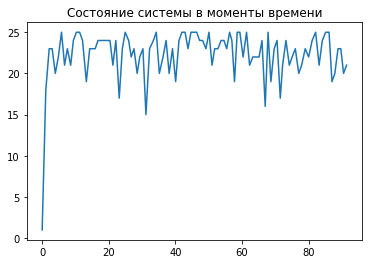

In [ ]:
volume = 10000
qs = QueueSystem(60, 2, 4, 20, 5)
for _ in range(volume):
    qs.iterate()

plt.plot(qs.state_times[::volume // 100], qs.states[::volume // 100])
plt.title('Состояние системы в моменты времени')
plt.show()

states = qs.states

Финальные вероятности состояний

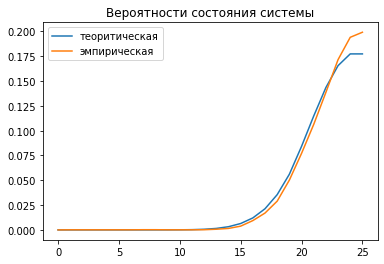

In [ ]:
theor_final_probs = qs.get_final_probs()
emp_final_probs = [0] * len(theor_final_probs)
for state in states:
  emp_final_probs[state] += 1
emp_final_probs = np.array(emp_final_probs) / len(states)
plt.plot(list(range(qs.n + qs.m + 1)), theor_final_probs)
plt.plot(list(range(qs.n + qs.m + 1)), emp_final_probs)
plt.legend(['теоритическая', 'эмпирическая'])
plt.title('Вероятности состояния системы')
plt.show()

Абсолютная пропускная способность

In [ ]:
theor_abs_throughput = qs.get_abs_throughput()
print(f'Теоритическая пропускная способность: {theor_abs_throughput}')
emp_abs_throughput = qs.lambd * qs.backward_count / qs.forward_count
print(f'Эмпирическая пропускная способность: {emp_abs_throughput}')

Теоритическая пропускная способность: 49.35767420168195
Эмпирическая пропускная способность: 48.972030512168544


Вероятность отказа

In [ ]:
theor_refusal_prob = qs.get_refusal_prob()
print(f'Теоритическая вероятность отказа в обслуживании: {theor_refusal_prob}')
emp_refusal_prob = qs.refusal_count / qs.forward_count
print(f'Эмпирическая вероятность отказа в обслуживании : {emp_refusal_prob}' )

Теоритическая вероятность отказа в обслуживании: 0.17737209663863418
Эмпирическая вероятность отказа в обслуживании : 0.1798038503450781


Среднее число заявок в СМО

In [ ]:
theor_avg_orders_in_QS = qs.get_avg_orders_in_QS()
print(f'Теоритическое среднее число заявок в СМО: {theor_avg_orders_in_QS}')
emp_avg_orders_in_QS = sum([state if state <= qs.n else qs.n for state in states]) / len(states)
print(f'Эмпирическое среднее число заявок в СМО : {emp_avg_orders_in_QS}')

Теоритическое среднее число заявок в СМО: 19.689399438417666
Эмпирическое среднее число заявок в СМО : 19.7508


Среднее число заявок в очереди

In [ ]:
theor_avg_orders_in_queue = qs.get_avg_orders_in_queue()
print(f'Теоритическое среднее число заявок в очереди: {theor_avg_orders_in_queue}')
queue_states = []
for state in states:
    queue_states.append(max(0, state - qs.n))  
emp_avg_orders_in_queue = np.mean(queue_states)
print(f'Эмпирическое среднее число заявок в очереди: {emp_avg_orders_in_queue}')

Теоритическое среднее число заявок в очереди: 2.494718831211652
Эмпирическое среднее число заявок в очереди: 2.6707


Среднее время пребывания заявки в СМО

In [ ]:
theor_avg_time_QS = qs.get_avg_time_QS()
print(f'Теоритическое среднее время пребывания заявки в СМО: {theor_avg_time_QS}')
emp_avg_time_QS = np.mean([qs.dequeues[i] - qs.enqueues[i] for i in range(len(qs.dequeues))])
print(f'Эмпирическое среднее время пребывания заявки в СМО: {emp_avg_time_QS}')

Теоритическое среднее время пребывания заявки в СМО: 0.4528925988675438
Эмпирическое среднее время пребывания заявки в СМО: 0.4560924105847068


Среднее время пребывания заявки в очереди

In [ ]:
theor_avg_time_queue = qs.get_avg_time_queue()
print(f'Теоритическое среднее время заявки в очереди: {theor_avg_time_queue}')
emp_avg_time_queue = emp_avg_orders_in_queue / qs.lambd
print(f'Эмпирическое время прибывания заявки в очереди: {emp_avg_time_queue}')

Теоритическое среднее время заявки в очереди: 0.04157864718686087
Эмпирическое время прибывания заявки в очереди: 0.044511666666666665


In [ ]:
def plot_step(lambd, mu, nu, n, m):
  qs = QueueSystem(lambd, mu, nu, n, m)
  while not qs.state_times or qs.state_times[-1] < 1000:
      qs.iterate()
  volume = len(qs.state_times)
  plt.plot(qs.state_times[::volume // 100], qs.states[::volume // 100])

def plot_probs(lambd, mu, nu, n, m):
  volume = 1000000
  qs = QueueSystem(lambd, mu, nu, n, m)
  for _ in range(volume):
      qs.iterate()

  states = qs.states
  emp_final_probs = [0] * (qs.n + qs.m + 1)
  for state in states:
    emp_final_probs[state] += 1
  emp_final_probs = np.array(emp_final_probs) / len(states)
  theor_final_probs = qs.get_final_probs()
  plt.plot(list(range(qs.n + qs.m + 1)), emp_final_probs)
  plt.plot(list(range(qs.n + qs.m + 1)), theor_final_probs)
    

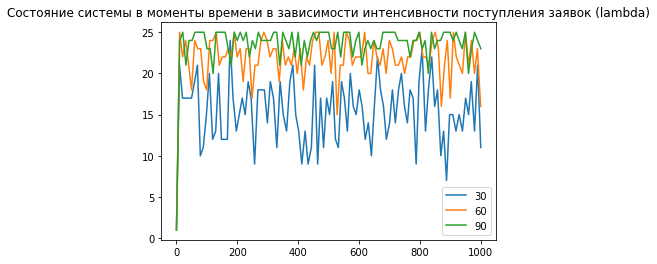

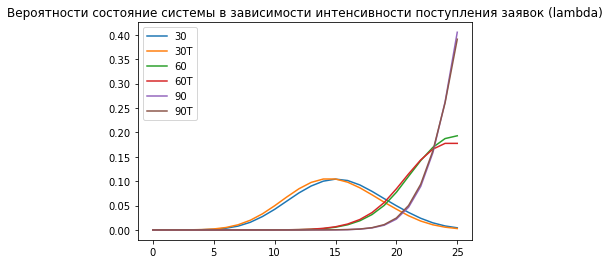

In [ ]:
plot_step(30, 2, 4, 20, 5)
plot_step(60, 2, 4, 20, 5)
plot_step(90, 2, 4, 20, 5)
plt.title('Состояние системы в моменты времени в зависимости интенсивности поступления заявок (lambda)')
plt.legend(['30', '60', '90'])
plt.show()

plot_probs(30, 2, 4, 20, 5)
plot_probs(60, 2, 4, 20, 5)
plot_probs(90, 2, 4, 20, 5)
plt.title('Вероятности состояние системы в зависимости интенсивности поступления заявок (lambda)')
plt.legend(['30', '30T', '60', '60T', '90', '90T'])
plt.show()

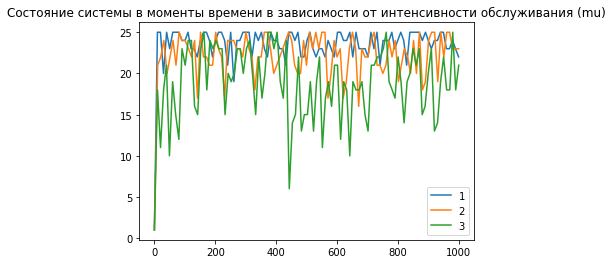

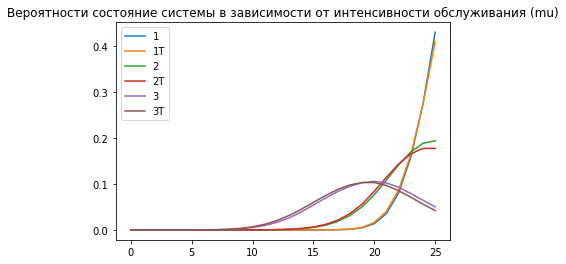

In [ ]:
plot_step(60, 1, 4, 20, 5)
plot_step(60, 2, 4, 20, 5)
plot_step(60, 3, 4, 20, 5)
plt.title('Состояние системы в моменты времени в зависимости от интенсивности обслуживания (mu)')
plt.legend(['1', '2', '3'])
plt.show()

plot_probs(60, 1, 4, 20, 5)
plot_probs(60, 2, 4, 20, 5)
plot_probs(60, 3, 4, 20, 5)
plt.title('Вероятности состояние системы в зависимости от интенсивности обслуживания (mu)')
plt.legend(['1', '1T', '2', '2T', '3', '3T'])
plt.show()

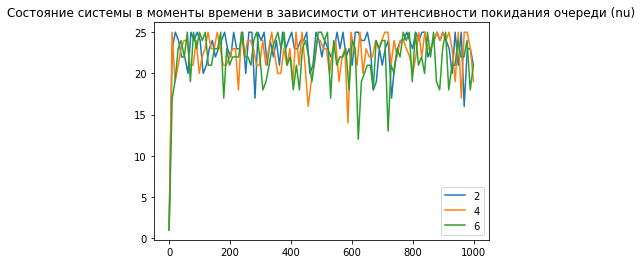

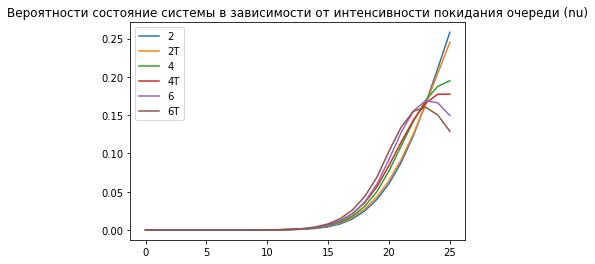

In [ ]:
plot_step(60, 2, 2, 20, 5)
plot_step(60, 2, 4, 20, 5)
plot_step(60, 2, 6, 20, 5)
plt.title('Состояние системы в моменты времени в зависимости от интенсивности покидания очереди (nu)')
plt.legend(['2', '4', '6'])
plt.show()

plot_probs(60, 2, 2, 20, 5)
plot_probs(60, 2, 4, 20, 5)
plot_probs(60, 2, 6, 20, 5)
plt.title('Вероятности состояние системы в зависимости от интенсивности покидания очереди (nu)')
plt.legend(['2', '2T', '4', '4T', '6', '6T'])
plt.show()

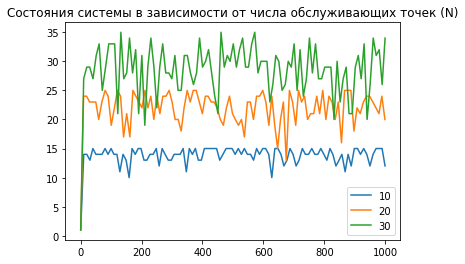

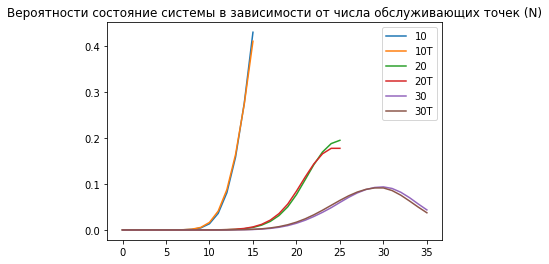

In [ ]:
plot_step(60, 2, 4, 10, 5)
plot_step(60, 2, 4, 20, 5)
plot_step(60, 2, 4, 30, 5)
plt.title('Состояния системы в зависимости от числа обслуживающих точек (N)')
plt.legend(['10', '20', '30'])
plt.show()

plot_probs(60, 2, 4, 10, 5)
plot_probs(60, 2, 4, 20, 5)
plot_probs(60, 2, 4, 30, 5)
plt.title('Вероятности состояние системы в зависимости от числа обслуживающих точек (N)')
plt.legend(['10', '10T', '20', '20T', '30', '30T'])
plt.show()

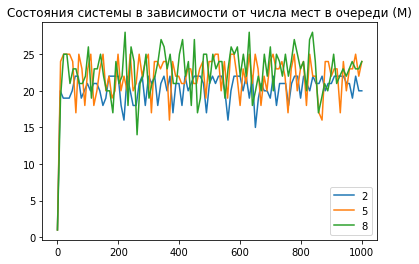

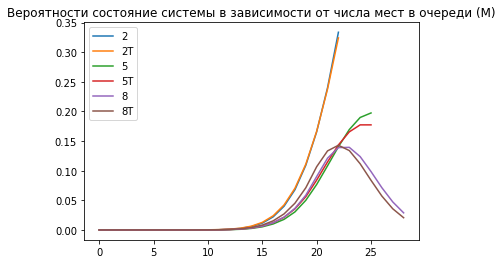

In [ ]:
plot_step(60, 2, 2, 20, 2)
plot_step(60, 2, 4, 20, 5)
plot_step(60, 2, 8, 20, 8)
plt.title('Состояния системы в зависимости от числа мест в очереди (M)')
plt.legend(['2', '5', '8'])
plt.show()

plot_probs(60, 2, 2, 20, 2)
plot_probs(60, 2, 4, 20, 5)
plot_probs(60, 2, 8, 20, 8)
plt.title('Вероятности состояние системы в зависимости от числа мест в очереди (M)')
plt.legend(['2', '2T', '5', '5T', '8', '8T'])
plt.show()